## **Installation**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import warnings
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

# Ignoring warnings
warnings.filterwarnings("ignore")

## **Data Import**

In [2]:
df = pd.read_csv("strokes.csv")

In [3]:
selected_columns = ['player_id', 'last_name', 'round','hole','hole_score','par_value','yardage', 'shot', 'shot_type', 'num_of_strokes',
       'from_location_scorer', 'from_location_laser', 'to_location_scorer',
       'to_location_laser', 'distance', 'distance_to_pin', 'in_the_hole',
       'around_the_green', 'first_putt', 'dist_to_hole_after_shot', 'time',
       'lie', 'elevation', 'slope', 'x', 'y', 'z', 'dist_from_center',
       'dist_from_edge']  # Add the column names you want to select
df = df[selected_columns].copy()

shot_1 = df.loc[df['shot'] == 1]

driving_data = shot_1[shot_1['par_value'].isin([4,5])]

driving_data['Drive_length'] = driving_data['distance_to_pin'] - driving_data['dist_to_hole_after_shot']

righty_or_lefty = {    
    'Mickelson':'L',
    'Toms':'R',
    'Woodland':'R',
    'Simpson':'R',
    'Day':'R',
    'Snedeker':'R',
    'Watney':'R',
    'Reavie':'R',
    'Watson':'R',
    'Dufner':'R',
    'Byrd':'R',
    'Haas':'R',
    'Mahan':'R',
    'Yang':'R',
    'Scott':'R',
    'Choi':'R',
    'Donald':'R',
    'Van Pelt':'R',
    'Kuchar':'R',
    'Rose':'R',
    'Ogilvy':'R',
    'Howell III':'R',
    'Wilson':'R',
    'Jacobson':'R',
    'Senden':'R',
    'Singh':'R',
    'Johnson':'R',
    'Baddeley':'R',
    'Bradley':'R',
    'Stricker':'R'
}
driving_data['Golfer_hand'] = driving_data['last_name'].map(righty_or_lefty)

In [4]:
sg_drive_calc = driving_data.groupby(['round', 'hole']).agg({
    'Drive_length': 'mean',
    'dist_from_center': 'mean',
    'hole_score': 'mean'  # Add this line for 'hole_score'
}).reset_index()

sg_drive_calc.rename(columns={
    'Drive_length': 'avg_drv_lngth_per_round',
    'dist_from_center': 'avg_dist_from_center_per_round',
    'hole_score': 'avg_hole_score_per_round'  # Rename for clarity
}, inplace=True)

In [5]:
# Assuming sg_calc and condensed_df are your DataFrames
driving_data['Dg_per_hole_per_round_per_player'] = driving_data.apply(
    lambda row: sg_drive_calc.loc[(sg_drive_calc['round'] == row['round']) & (sg_drive_calc['hole'] == row['hole']), 'avg_drv_lngth_per_round'].iloc[0] - row['Drive_length'],
    axis=1
)

driving_data['avg_drv_lngth_per_round'] = driving_data.apply(
    lambda row: sg_drive_calc.loc[(sg_drive_calc['round'] == row['round']) & (sg_drive_calc['hole'] == row['hole']), 'avg_drv_lngth_per_round'].iloc[0],
    axis=1
)

# Display the resulting DataFrame
driving_data['Dg_per_hole_per_round_per_player'] = driving_data['Dg_per_hole_per_round_per_player'] * -1

# Assuming sg_calc and condensed_df are your DataFrames
driving_data['sg_per_hole_per_round_per_player'] = driving_data.apply(
    lambda row: sg_drive_calc.loc[(sg_drive_calc['round'] == row['round']) & (sg_drive_calc['hole'] == row['hole']), 'avg_hole_score_per_round'].iloc[0] - row['hole_score'],
    axis=1
)

driving_data['avg_hole_score_per_round'] = driving_data.apply(
    lambda row: sg_drive_calc.loc[(sg_drive_calc['round'] == row['round']) & (sg_drive_calc['hole'] == row['hole']), 'avg_hole_score_per_round'].iloc[0],
    axis=1
)

# Assuming sg_calc and condensed_df are your DataFrames
driving_data['cg_per_hole_per_round_per_player'] = driving_data.apply(
    lambda row: sg_drive_calc.loc[(sg_drive_calc['round'] == row['round']) & (sg_drive_calc['hole'] == row['hole']), 'avg_dist_from_center_per_round'].iloc[0] - row['dist_from_center'],
    axis=1
)

driving_data['avg_dist_from_center_per_round'] = driving_data.apply(
    lambda row: sg_drive_calc.loc[(sg_drive_calc['round'] == row['round']) & (sg_drive_calc['hole'] == row['hole']), 'avg_dist_from_center_per_round'].iloc[0],
    axis=1
)

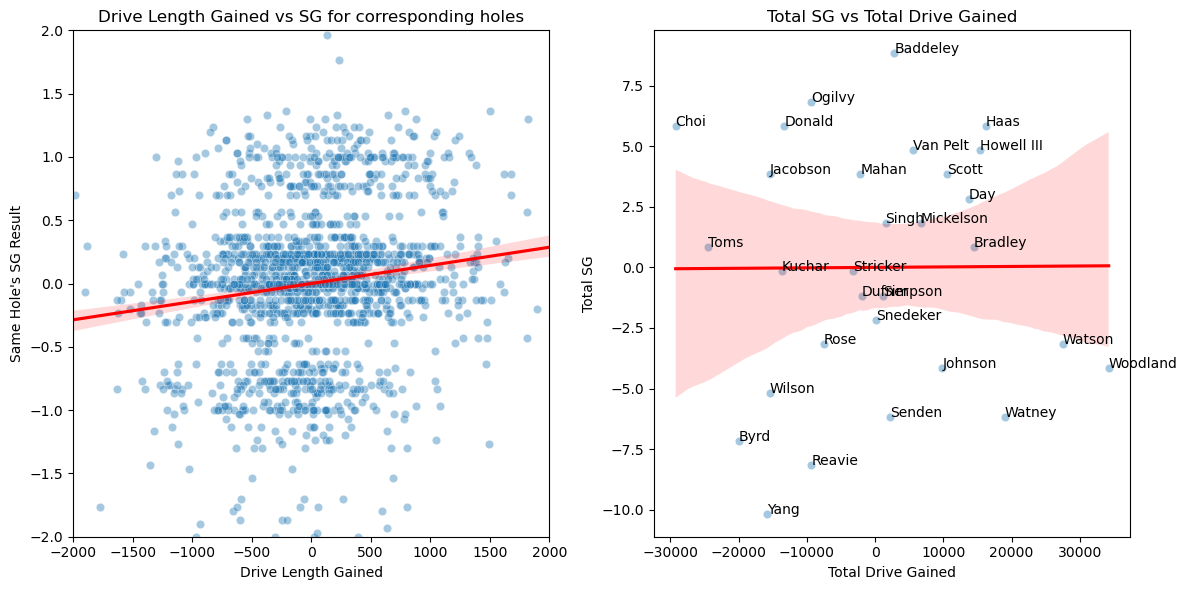

In [6]:
# Plot 1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

sns.scatterplot(data=driving_data, x='Dg_per_hole_per_round_per_player', y='sg_per_hole_per_round_per_player', alpha=0.4, palette='viridis')
sns.regplot(data=driving_data, x='Dg_per_hole_per_round_per_player', y='sg_per_hole_per_round_per_player', scatter=False, color='red',order=1)

plt.title('Drive Length Gained vs SG for corresponding holes')
plt.xlabel('Drive Length Gained')
plt.ylabel("Same Hole's SG Result")
plt.xlim(-2000, 2000)
plt.ylim(-2, 2)

# Plot 2
plt.subplot(1, 2, 2)

result = driving_data.groupby('last_name').agg({
    'Dg_per_hole_per_round_per_player': 'sum',
    'sg_per_hole_per_round_per_player': 'sum'
}).reset_index().sort_values(by='Dg_per_hole_per_round_per_player', ascending=False)

sns.scatterplot(data=result, x=result.Dg_per_hole_per_round_per_player, y=result.sg_per_hole_per_round_per_player, alpha=0.4)
sns.regplot(data=result, x='Dg_per_hole_per_round_per_player', y='sg_per_hole_per_round_per_player', scatter=False, color='red',order=1)

plt.title('Total SG vs Total Drive Gained')
plt.xlabel('Total Drive Gained')
plt.ylabel('Total SG')

for index, row in result.iterrows():
    plt.text(row['Dg_per_hole_per_round_per_player'], row['sg_per_hole_per_round_per_player'], row['last_name'], fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


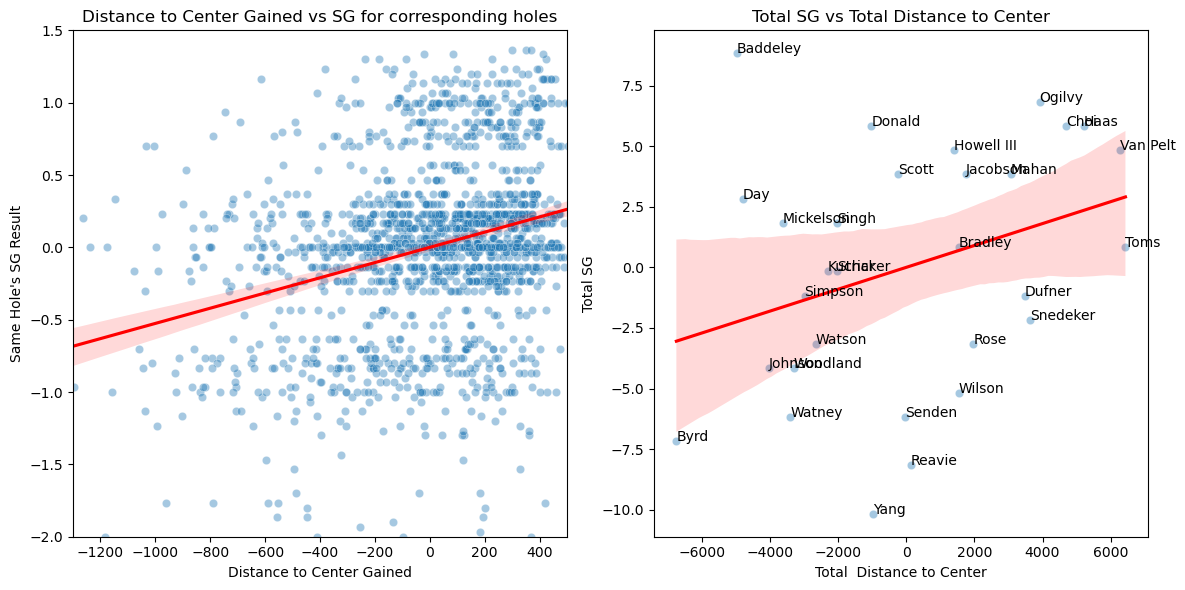

In [7]:
# Plot 1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

sns.scatterplot(data=driving_data, x='cg_per_hole_per_round_per_player', y='sg_per_hole_per_round_per_player', alpha=0.4, palette='viridis')
sns.regplot(data=driving_data, x='cg_per_hole_per_round_per_player', y='sg_per_hole_per_round_per_player', scatter=False, color='red',order=1)
plt.title('Distance to Center Gained vs SG for corresponding holes')
plt.xlabel('Distance to Center Gained')
plt.ylabel("Same Hole's SG Result")
plt.xlim(-1300, 500)
plt.ylim(-2,1.5)

# Plot 2
plt.subplot(1, 2, 2)

result = driving_data.groupby('last_name').agg({
    'cg_per_hole_per_round_per_player': 'sum',
    'sg_per_hole_per_round_per_player': 'sum'
}).reset_index().sort_values(by='cg_per_hole_per_round_per_player', ascending=False)

sns.scatterplot(data=result, x=result.cg_per_hole_per_round_per_player, y=result.sg_per_hole_per_round_per_player, alpha=0.4)
sns.regplot(data=result, x='cg_per_hole_per_round_per_player', y='sg_per_hole_per_round_per_player', scatter=False, color='red', order=1)

plt.title('Total SG vs Total Distance to Center')
plt.xlabel('Total  Distance to Center')
plt.ylabel('Total SG')

for index, row in result.iterrows():
    plt.text(row['cg_per_hole_per_round_per_player'], row['sg_per_hole_per_round_per_player'], row['last_name'], fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [8]:
fig = px.scatter_3d(driving_data, 
                    x='cg_per_hole_per_round_per_player', 
                    y='Dg_per_hole_per_round_per_player', 
                    z='sg_per_hole_per_round_per_player', 
                    color='sg_per_hole_per_round_per_player',
                    opacity=0.1)

fig.update_layout(width=800, height=800, title = 'CG vs DG vs SG')

fig.update_scenes(
    xaxis=dict(range=[-1300, 500]),
)

fig.update_scenes(
    yaxis=dict(range=[-1300,1000]),
)

fig.update_scenes(
    zaxis=dict(range=[-3, 2]),
)

fig.show()